In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danylosokrut","key":"75768029e1c82c4111d9fff1b99600fc"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip

 99% 805M/812M [00:06<00:00, 185MB/s]
100% 812M/812M [00:06<00:00, 130MB/s]


In [4]:
!unzip -qq train.zip

In [ ]:
### SETUP DATA FOR TRAINING & TESTING

In [5]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
 for category in ("cat", "dog"):
  dir = new_base_dir / subset_name / category
  os.makedirs(dir)
  fnames = [f"{category}.{i}.jpg"
            for i in range(start_index, end_index)]
  for fname in fnames:
      shutil.copyfile(src=original_dir / fname,
                      dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [6]:
### Create small convnet for dog & cat classification:
from tensorflow import keras
from tensorflow.keras import layers


In [7]:
### Create small convnet for dog & cat classification:
data_augmentation = keras.Sequential(
 [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
 ]
)


In [8]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

In [9]:
model.compile(loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [10]:
###working with image_dataset_from_directory tensorflow.keras function:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
    ]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 21s 110ms/step - loss: 0.6972 - accuracy: 0.4895 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 78ms/step - loss: 0.6935 - accuracy: 0.5325 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 88ms/step - loss: 0.7078 - accuracy: 0.5445 - val_loss: 0.6702 - val_accuracy: 0.6360
Epoch 4/100
63/63 [==============================] - 5s 80ms/step - loss: 0.6773 - accuracy: 0.5820 - val_loss: 0.7182 - val_accuracy: 0.5060
Epoch 5/100
63/63 [==============================] - 5s 69ms/step - loss: 0.6547 - accuracy: 0.6275 - val_loss: 0.8352 - val_accuracy: 0.5230
Epoch 6/100
63/63 [==============================] - 7s 106ms/step - loss: 0.6712 - accuracy: 0.6175 - val_loss: 0.6443 - val_accuracy: 0.6460
Epoch 7/100
63/63 [==============================] - 6s 88ms/step - loss: 0.6400 - accuracy: 0.6550 - val_loss: 0.6181 - val_accuracy: 0.6490
Epo

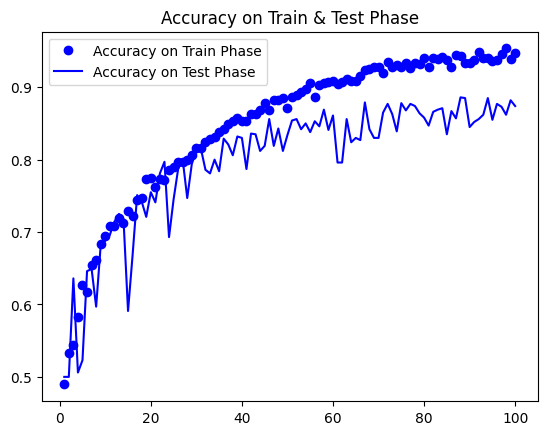

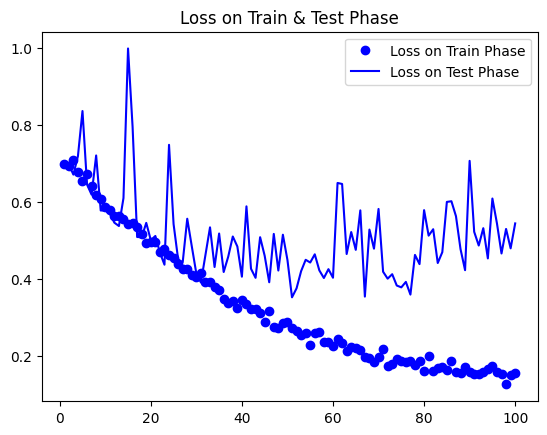

In [12]:
### DRAW GRAPHIC TO SHOW ACCURACY IN TRAIN & TEST DATASETS DATA
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Accuracy on Train Phase")
plt.plot(epochs, val_accuracy, "b", label="Accuracy on Test Phase")
plt.title("Accuracy on Train & Test Phase")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Loss on Train Phase")
plt.plot(epochs, val_loss, "b", label="Loss on Test Phase")
plt.title("Loss on Train & Test Phase")
plt.legend()
plt.show()


In [13]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.txt")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 33ms/step - loss: 0.4209 - accuracy: 0.8250
Test accuracy: 0.825


In [14]:
files.download('convnet_from_scratch_with_augmentation.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
model.save("conv_model.keras")